In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import random
from pathlib import Path

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

2025-04-30 08:28:14.567529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746001694.771216      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746001694.830990      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.18.0


In [4]:
source_dir = '/kaggle/input/garbage-classification-v2/garbage-dataset'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Membagi 20% untuk validasi
)

# Membaca data training dan validation menggunakan split
train_generator = train_datagen.flow_from_directory(
    source_dir, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Menggunakan subset training (80% data)
)

validation_generator = train_datagen.flow_from_directory(
    source_dir,  # Ganti dengan path folder dataset
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Menggunakan subset validation (20% data)
)


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


In [6]:
early_stop=EarlyStopping(monitor='val_loss',patience=10)
checkpoint=ModelCheckpoint(filepath='/kaggle/working/best.keras',monitor='val_loss',save_best_only=True,mode='auto')

In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipykernel_31/1040116440.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)
I0000 00:00:1746001985.985444      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746001985.986136      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10, 
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746001997.884647     126 service.cc:148] XLA service 0x7de5d41117f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746001997.885614     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746001997.885646     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746001998.752414     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/495 ━━━━━━━━━━━━━━━━━━━━ 1:55:59 14s/step - accuracy: 0.0938 - loss: 2.7302

I0000 00:00:1746002002.858985     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


495/495 ━━━━━━━━━━━━━━━━━━━━ 168s 312ms/step - accuracy: 0.8382 - loss: 0.5188 - val_accuracy: 0.9142 - val_loss: 0.2601
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.9451 - loss: 0.1629 - val_accuracy: 0.9063 - val_loss: 0.3122
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 121ms/step - accuracy: 0.9651 - loss: 0.0975 - val_accuracy: 0.9288 - val_loss: 0.2623
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - accuracy: 0.9831 - loss: 0.0543 - val_accuracy: 0.9131 - val_loss: 0.3127
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 60s 120ms/step - accuracy: 0.9842 - loss: 0.0431 - val_accuracy: 0.9202 - val_loss: 0.3204
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 121ms/step - accuracy: 0.9912 - loss: 0.0268 - val_accuracy: 0.9195 - val_loss: 0.3461
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - accuracy: 0.9892 - loss: 0.0308 - val_accuracy: 0.9205 - val_loss: 0.3496
Epoch 8/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 62s 124ms/step - accuracy: 0.9903 - loss: 0.0288 - va

In [9]:
train_generator.class_indices.keys()

dict_keys(['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash'])

In [10]:
loss, accuracy = model.evaluate(validation_generator)

print(f'Loss: {loss}')
print(f'Akurasi: {accuracy}')

124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.9297 - loss: 0.3380
Loss: 0.3544290065765381
Akurasi: 0.9285895228385925


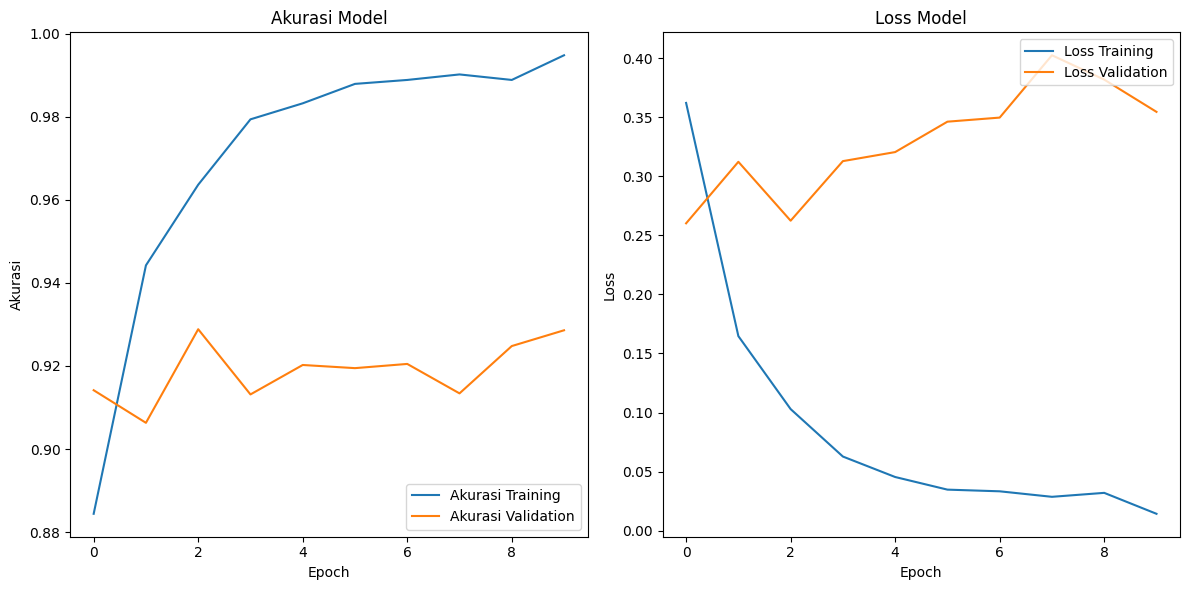

In [11]:
plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [14]:
model.save('my_model.h5')

In [12]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138431283733968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138431282544080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138429753180432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138431282543504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138431282544272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138431282543696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138429753182352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138429753180240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138429753181008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138429753181968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138429753182160:

In [13]:
tfjs.converters.save_keras_model(model, 'model_tfjs') 

failed to lookup keras version from the file,
    this is likely a weight only file


In [15]:
!zip -r /kaggle/working/model.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/my_model.h5 (deflated 9%)
  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/assets/ (stored 0%)
  adding: kaggle/working/saved_model/variables/ (stored 0%)
  adding: kaggle/working/saved_model/variables/variables.index (deflated 78%)
  adding: kaggle/working/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/saved_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/saved_model/saved_model.pb (deflated 90%)
  adding: kaggle/working/best.keras (deflated 8%)
  adding: kaggle/working/model_tfjs/ (stored 0%)
  adding: kaggle/working/model_tfjs/group1-shard4of4.bin (deflated 7%)
  adding: kaggle/working/model_tfjs/group1-shard1of4.bin (deflated 7%)
  adding: kaggle/working/model_tfjs/group1-shard2of4.bin (deflated 7%)
  adding: kaggle/working/model_tfjs/group1-shard3of4.bin (deflated 7%)
  adding: kaggle/working/model_tfjs/model.json (deflated 97%)